# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ndcg_score, f1_score, accuracy_score, roc_auc_score
import shap
import warnings
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import StratifiedKFold
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

# Read and merge data

In [185]:
train = pd.read_csv('train.csv', dtype={'msno' : 'category',
                                                'source_system_tab' : 'category',
                                                  'source_screen_name' : 'category',
                                                  'source_type' : 'category',
                                                  'target' : np.uint8,
                                                  'song_id' : 'category'})
test = pd.read_csv('test.csv', dtype={'msno' : 'category',
                                                'source_system_tab' : 'category',
                                                'source_screen_name' : 'category',
                                                'source_type' : 'category',
                                                'song_id' : 'category'})
songs = pd.read_csv('songs.csv',dtype={'genre_ids': 'category',
                                                  'language' : 'category',
                                                  'artist_name' : 'category',
                                                  'composer' : 'category',
                                                  'lyricist' : 'category',
                                                  'song_id' : 'category'})
members = pd.read_csv('members.csv',dtype={'city' : 'category',
                                                      'bd' : np.uint8,
                                                      'gender' : 'category',
                                                      'registered_via' : 'category'},
                     parse_dates=['registration_init_time','expiration_date'])
songs_extra = pd.read_csv('song_extra_info.csv')
train = train.merge(songs, on='song_id', how='left')
test = test.merge(songs, on='song_id', how='left')

members['membership_days'] = members['expiration_date'].subtract(members['registration_init_time']).dt.days.astype(int)

members['registration_year'] = members['registration_init_time'].dt.year
members['registration_month'] = members['registration_init_time'].dt.month
members['registration_date'] = members['registration_init_time'].dt.day

members['expiration_year'] = members['expiration_date'].dt.year
members['expiration_month'] = members['expiration_date'].dt.month
members['expiration_date'] = members['expiration_date'].dt.day
members = members.drop(['registration_init_time'], axis=1)

def isrc_to_year(isrc):
    if type(isrc) == str:
        if int(isrc[5:7]) > 17:
            return 1900 + int(isrc[5:7])
        else:
            return 2000 + int(isrc[5:7])
    else:
        return np.nan
        
songs_extra['song_year'] = songs_extra['isrc'].apply(isrc_to_year)
songs_extra.drop(['isrc', 'name'], axis = 1, inplace = True)

train = train.merge(members, on='msno', how='left')
test = test.merge(members, on='msno', how='left')

train = train.merge(songs_extra, on = 'song_id', how = 'left')
train.song_length.fillna(200000,inplace=True)
train.song_length = train.song_length.astype(np.uint32)
train.song_id = train.song_id.astype('category')


test = test.merge(songs_extra, on = 'song_id', how = 'left')
test.song_length.fillna(200000,inplace=True)
test.song_length = test.song_length.astype(np.uint32)
test.song_id = test.song_id.astype('category')
train = pd.concat([
        train.select_dtypes([], ['object']),
        train.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
        ], axis=1)

test = pd.concat([
        test.select_dtypes([], ['object']),
        test.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
        ], axis=1)

# EDA

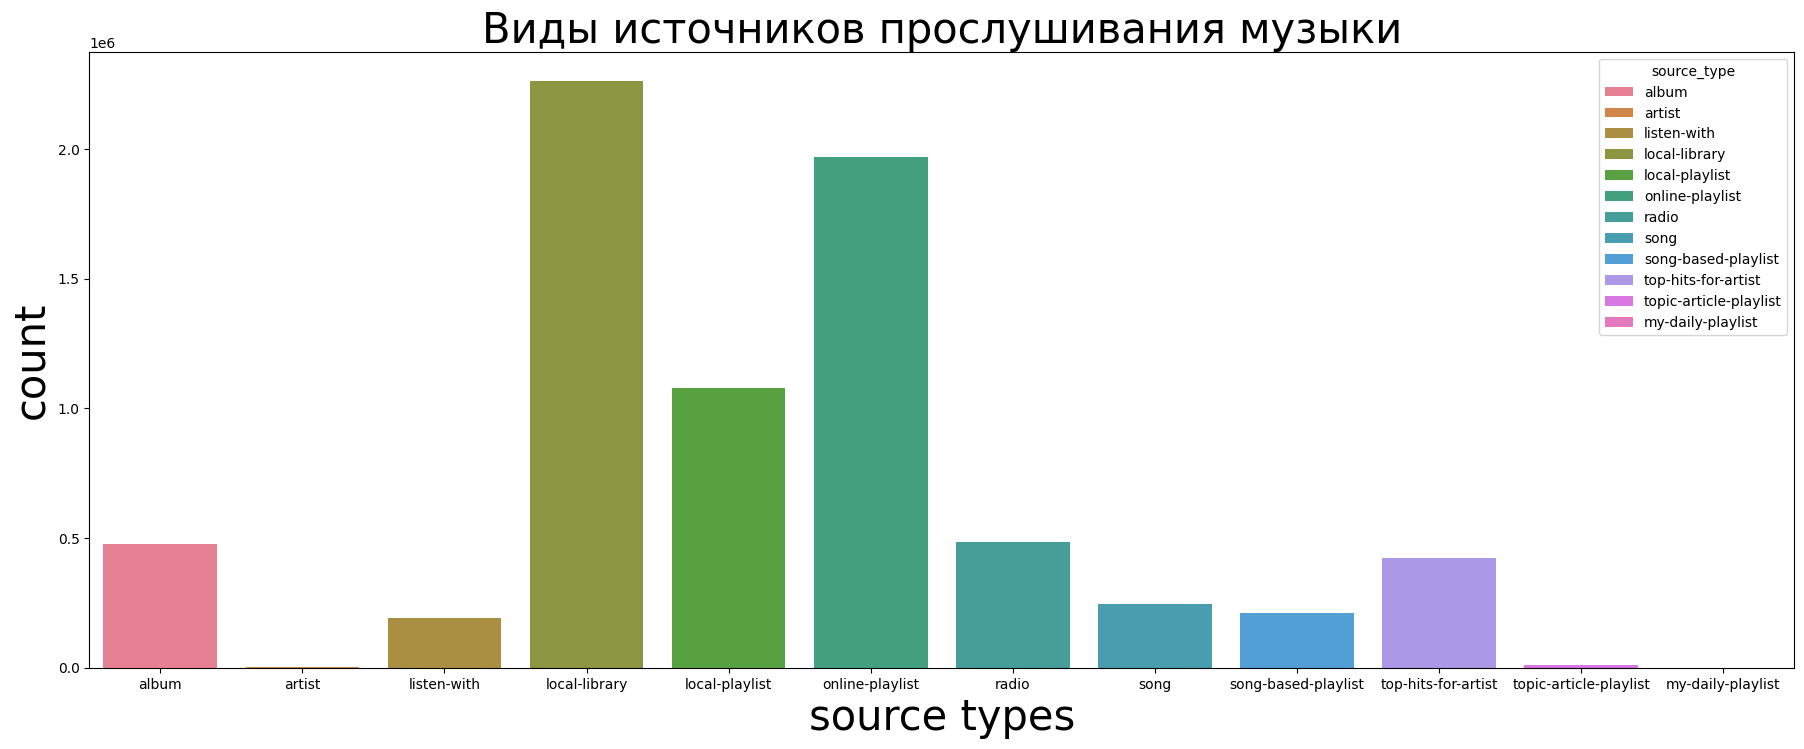

In [189]:
plt.figure(figsize=(22, 8))
sns.countplot(x='source_type',hue='source_type',data=train)
plt.xlabel('source types',fontsize=30)
plt.ylabel('count',fontsize=30)
plt.title('Виды источников прослушивания музыки',fontsize=30)
plt.show()

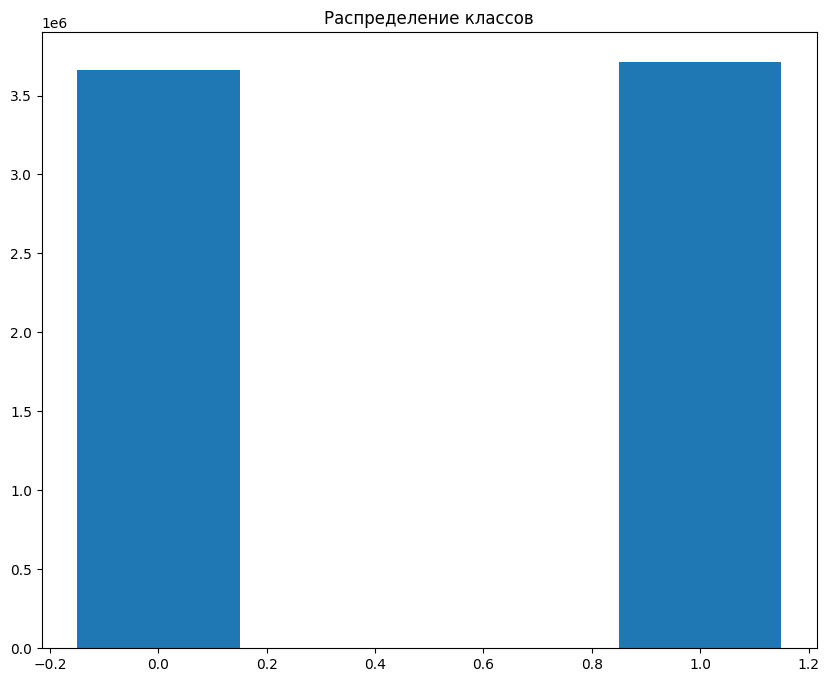

In [187]:
vc = train['target'].value_counts()
plt.figure(figsize=(10, 8))
plt.bar(vc.index, vc, width=0.3)
plt.title("Распределение классов")
plt.show()

# Data preprocessing
Источник: https://www.kaggle.com/code/vinnsvinay/introduction-to-boosting-using-lgbm-lb-0-68357

In [190]:
def lyricist_count(x):
    if x == 'no_lyricist':
        return 0
    else:
        return sum(map(x.count, ['|', '/', '\\', ';'])) + 1

train['lyricist'] = train['lyricist'].cat.add_categories('no_lyricist')
train['lyricist'].fillna('no_lyricist',inplace=True)
train['lyricists_count'] = train['lyricist'].apply(lyricist_count).astype(np.int8)
test['lyricist'] = test['lyricist'].cat.add_categories(['no_lyricist'])
test['lyricist'].fillna('no_lyricist',inplace=True)
test['lyricists_count'] = test['lyricist'].apply(lyricist_count).astype(np.int8)

def composer_count(x):
    if x == 'no_composer':
        return 0
    else:
        return sum(map(x.count, ['|', '/', '\\', ';'])) + 1

train['composer'] = train['composer'].cat.add_categories(['no_composer'])
train['composer'].fillna('no_composer',inplace=True)
train['composer_count'] = train['composer'].apply(composer_count).astype(np.int8)
test['composer'] = test['composer'].cat.add_categories(['no_composer'])
test['composer'].fillna('no_composer',inplace=True)
test['composer_count'] = test['composer'].apply(composer_count).astype(np.int8)

def is_featured(x):
    if 'feat' in str(x) :
        return 1
    return 0

train['artist_name'] = train['artist_name'].cat.add_categories(['no_artist'])
train['artist_name'].fillna('no_artist',inplace=True)
train['is_featured'] = train['artist_name'].apply(is_featured).astype(np.int8)
train['language'] = train['language'].cat.add_categories(['0'])
train['language'].fillna('0', inplace=True)
test['language'] = test['language'].cat.add_categories(['0'])
test['language'].fillna('0', inplace=True)
test['artist_name'] = test['artist_name'].cat.add_categories(['no_artist'])
test['artist_name'].fillna('no_artist',inplace=True)
test['is_featured'] = test['artist_name'].apply(is_featured).astype(np.int8)

def artist_count(x):
    if x == 'no_artist':
        return 0
    else:
        return x.count('and') + x.count(',') + x.count('feat') + x.count('&')

train['artist_count'] = train['artist_name'].apply(artist_count).astype(np.int8)
test['artist_count'] = test['artist_name'].apply(artist_count).astype(np.int8)

# if artist is same as composer
train['artist_composer'] = (np.asarray(train['artist_name']) == np.asarray(train['composer'])).astype(np.int8)
test['artist_composer'] = (np.asarray(test['artist_name']) == np.asarray(test['composer'])).astype(np.int8)


# if artist, lyricist and composer are all three same
train['artist_composer_lyricist'] = ((np.asarray(train['artist_name']) == np.asarray(train['composer'])) & 
                                     np.asarray((train['artist_name']) == np.asarray(train['lyricist'])) & 
                                     np.asarray((train['composer']) == np.asarray(train['lyricist']))).astype(np.int8)
test['artist_composer_lyricist'] = ((np.asarray(test['artist_name']) == np.asarray(test['composer'])) & 
                                    (np.asarray(test['artist_name']) == np.asarray(test['lyricist'])) &
                                    np.asarray((test['composer']) == np.asarray(test['lyricist']))).astype(np.int8)

# is song language 17 or 45. 
def song_lang_boolean(x):
    if '17.0' in str(x) or '45.0' in str(x):
        return 1
    return 0

train['song_lang_boolean'] = train['language'].apply(song_lang_boolean).astype(np.int8)
test['song_lang_boolean'] = test['language'].apply(song_lang_boolean).astype(np.int8)


_mean_song_length = np.mean(train['song_length'])
def smaller_song(x):
    if x < _mean_song_length:
        return 1
    return 0

train['smaller_song'] = train['song_length'].apply(smaller_song).astype(np.int8)
test['smaller_song'] = test['song_length'].apply(smaller_song).astype(np.int8)

_dict_count_song_played_train = train['song_id'].value_counts().to_dict()
_dict_count_song_played_test = test['song_id'].value_counts().to_dict()
def count_song_played(x):
    try:
        return _dict_count_song_played_train[x]
    except KeyError:
        try:
            return _dict_count_song_played_test[x]
        except KeyError:
            return 0
    

train['count_song_played'] = train['song_id'].apply(count_song_played).astype(np.int64)
test['count_song_played'] = test['song_id'].apply(count_song_played).astype(np.int64)

# number of times the artist has been played
_dict_count_artist_played_train = train['artist_name'].value_counts().to_dict()
_dict_count_artist_played_test = test['artist_name'].value_counts().to_dict()
def count_artist_played(x):
    try:
        return _dict_count_artist_played_train[x]
    except KeyError:
        try:
            return _dict_count_artist_played_test[x]
        except KeyError:
            return 0

train['count_artist_played'] = train['artist_name'].apply(count_artist_played).astype(np.int64)
test['count_artist_played'] = test['artist_name'].apply(count_artist_played).astype(np.int64)

for col in train.columns:
    if train[col].dtype == object:
        train[col] = train[col].astype('category')
        test[col] = test[col].astype('category')

X_train = train.drop(['target'], axis=1)
y_train = train['target'].values

X_test = test.drop(['id'], axis=1)
ids = test['id'].values

# Baseline LGBM модель

In [197]:
model = LGBMClassifier(learning_rate=0.1, random_state=0, objective='binary', device='cpu', verbosity = -1, boosting_type='gbdt')

In [156]:
cv = StratifiedKFold(5, shuffle=True, random_state=0)
cv_splits = cv.split(X_train, y_train)
roc_auc_scores = list()

for train_idx, val_idx in cv_splits:
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
    
    model.fit(X_train_fold, y_train_fold)
    
    y_val_prob = model.predict_proba(X_val_fold)
    roc = roc_auc_score(y_val_fold, y_val_prob[:, 1:].reshape(-1))
    roc_auc_scores.append(roc)
    
roc_auc_mean = np.mean(roc_auc_scores)
roc_auc_std = np.std(roc_auc_scores)
roc_auc_max = np.max(roc_auc_scores)
roc_auc_min = np.min(roc_auc_scores)

print(f'CV ROC-AUC: {roc_auc_mean:.3f} +/- {roc_auc_std:.3f}')
print(f'Max ROC-AUC: {roc_auc_max:.3f}')
print(f'Min ROC-AUC: {roc_auc_min:.3f}')
    

CV ROC-AUC: 0.767 +/- 0.000
Max ROC-AUC: 0.768
Min ROC-AUC: 0.767


# Post hoc analysis
Видно, что многие фичи не играют никакой роли, поэтому перед оптимизацией алгоритма их можно удалить.

c:\Python\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


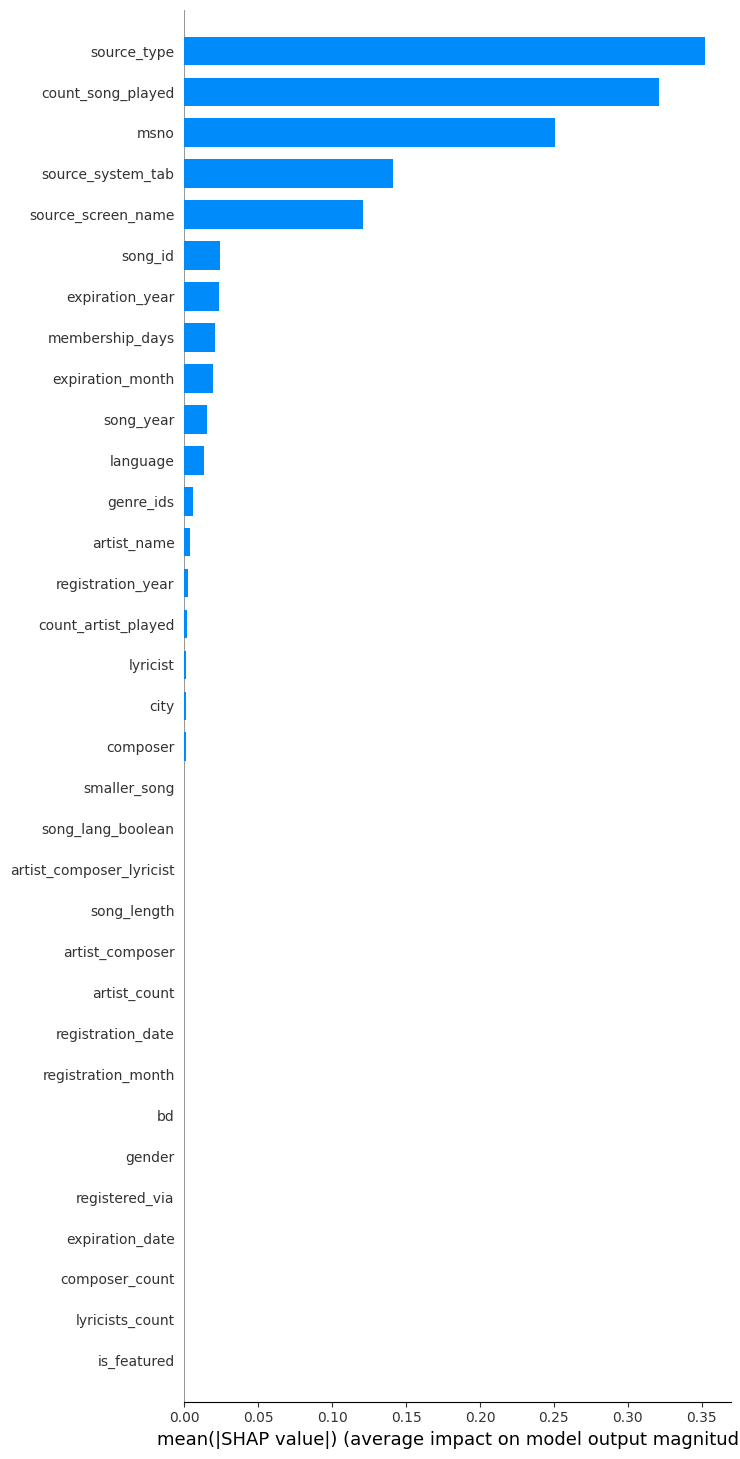

In [39]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=50, show=False)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [192]:
col_to_drop = [
       'target', 'bd', 'gender', 
       'registered_via', 'expiration_date', 'song_length',
       'registration_month', 'registration_date', 'lyricists_count',
       'composer_count', 'is_featured', 'artist_count', 'artist_composer',
       'artist_composer_lyricist', 'song_lang_boolean', 'smaller_song']
X_train = train.drop(col_to_drop, axis=1)
y_train = train['target'].values

col_to_drop_test = [
       'id', 'bd', 'gender', 
       'registered_via', 'expiration_date', 'song_length',
       'registration_month', 'registration_date', 'lyricists_count',
       'composer_count', 'is_featured', 'artist_count', 'artist_composer',
       'artist_composer_lyricist', 'song_lang_boolean', 'smaller_song']
X_test = test.drop(columns=col_to_drop_test)

In [194]:
X_train.shape

(7377418, 18)

# Optuna tuning
Подбираем гиперпараметры при помощи Optuna на основе SoTA алгоритмов. TPESampler настроен на то, чтобы сначала попробовать случайную оптимизацию для первых 75 испытаний, а затем выполнить байесовский поиск TPE. Мы также используем multivariate=True (добавленный в v2.2.0 в качестве экспериментальной функции), который, как сообщается, превосходит независимый TPE.

In [110]:
def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 100, 1200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 300, 1200),
        'subsample_for_bin': trial.suggest_int('subsample_for_bin', 20000, 300000),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 500),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.25, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 15)
    }
    
    cv = StratifiedKFold(3, shuffle=True, random_state=0)
    cv_splits = cv.split(X_train, y_train)
    roc_auc_scores = list()
    
    for train_idx, val_idx in cv_splits:
        model = LGBMClassifier(**params, random_state=0, objective='binary', metric='auc', verbosity = -1, boosting_type='gbdt', n_jobs=-1)
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
        
        model.fit(X_train_fold, y_train_fold)
        
        y_val_prob = model.predict_proba(X_val_fold)
        roc = roc_auc_score(y_val_fold, y_val_prob[:, 1:].reshape(-1))
        roc_auc_scores.append(roc)
        
    return np.mean(roc_auc_scores)

sqlite_db = "sqlite:///lgb.db"
study_name = "lgbm"
optimize = True
if optimize:
    study = optuna.create_study(storage=sqlite_db, study_name=study_name, 
                                sampler=TPESampler(n_startup_trials=40, multivariate=True, seed=0),
                                direction="maximize", load_if_exists=True)

    study.optimize(objective, n_trials=120)
    print(f"best optimized roc_auc: {study.best_value:0.5f}")
    print(f"best hyperparameters: {study.best_params}")

    lgbm_params = study.best_params

c:\Python\Lib\site-packages\optuna\samplers\_tpe\sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2024-04-30 08:22:03,033] A new study created in RDB with name: lgbm
[I 2024-04-30 08:26:39,711] Trial 0 finished with value: 0.7897675849955639 and parameters: {'num_leaves': 704, 'learning_rate': 0.16409119617016144, 'n_estimators': 843, 'subsample_for_bin': 172567, 'min_child_samples': 223, 'reg_alpha': 0.0028770084050677926, 'reg_lambda': 2.3761404778025532e-05, 'colsample_bytree': 0.9350638004692479, 'subsample': 0.9727470703757719, 'max_depth': 6}. Best is trial 0 with value: 0.7897675849955639.
[I 2024-04-30 08:38:13,803] Trial 1 finished with value: 0.8095993799670643 and parameters: {'num_leaves': 971, 'learning_rate': 0.0791729093402154, 'n_estimators': 811, 'subsample_for_bin': 279167, 'min_child_samples': 54, 'reg_alpha': 7.435205853060191e-09, 'reg_lambda': 1.5928833561691813e-09

KeyboardInterrupt: 

In [111]:
print(f"best optimized roc_auc: {study.best_value:0.5f}")
print(f"best hyperparameters: {study.best_params}")

best optimized roc_auc: 0.82433
best hyperparameters: {'num_leaves': 1193, 'learning_rate': 0.3252947065593061, 'n_estimators': 658, 'subsample_for_bin': 290838, 'min_child_samples': 109, 'reg_alpha': 0.006094394241324935, 'reg_lambda': 0.03881468371405116, 'colsample_bytree': 0.9457053175036342, 'subsample': 0.2960365456796449, 'max_depth': 15}


# Final model

In [204]:
params = {
    'num_leaves': 1193, 
    'learning_rate': 0.3252947065593061, 
    'n_estimators': 658, 
    'subsample_for_bin': 290838, 
    'min_child_samples': 109, 
    'reg_alpha': 0.006094394241324935,
    'reg_lambda': 0.03881468371405116, 
    'colsample_bytree': 0.9457053175036342, 
    'subsample': 0.2960365456796449, 
    'max_depth': 15,
    'random_state': 0, 
    'objective': 'binary', 
    'metric': 'auc', 
    'verbosity': -1, 
    'boosting_type': 'gbdt', 
    'n_jobs': -1,
}
X_tr, X_te, y_tr, y_te = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=0)

model = LGBMClassifier(**params)
model.fit(X_tr, y_tr)

LGBMClassifier(colsample_bytree=0.9457053175036342,
               learning_rate=0.3252947065593061, max_depth=15, metric='auc',
               min_child_samples=109, n_estimators=658, n_jobs=-1,
               num_leaves=1193, objective='binary', random_state=0,
               reg_alpha=0.006094394241324935, reg_lambda=0.03881468371405116,
               subsample=0.2960365456796449, subsample_for_bin=290838,
               verbosity=-1)

In [116]:
logits = model.predict_proba(X_te)

# Оценка модели
Делю датасет на выборки в соотношении 0.8:02 и использую NDCG, ROC AUC, F1, ACCURACY для оценки модели. Они хорошо подходят для задач бинарной классификации и рекоммендательных систем. Accuracy тут можно брать потому что нет дисбаланса классов.

In [198]:
probabilities = logits[:, 1]
eval = pd.DataFrame({
    'probability': probabilities,
    'true_label': y_te
})

data_sorted = eval.sort_values(by='probability', ascending=False)

# Подготовка матрицы оценок и истинных релевантностей
scores_matrix = data_sorted['probability'].values.reshape(1, -1)
true_relevance = data_sorted['true_label'].values.reshape(1, -1)

# Расчет NDCG at 20
ndcg_at_20 = ndcg_score(true_relevance, scores_matrix, k=20)
print("NDCG at 20:", ndcg_at_20)

NDCG at 20: 0.9999999999999999


In [199]:
roc_auc_score(data_sorted['true_label'], data_sorted['probability'])

0.8282048730436896

In [200]:
f1_score(data_sorted['true_label'], data_sorted['probability'].round())

0.7479993423051393

In [201]:
accuracy_score(data_sorted['true_label'], data_sorted['probability'].round())

0.7475885878803159

# Final submission

In [205]:
model.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.9457053175036342,
               learning_rate=0.3252947065593061, max_depth=15, metric='auc',
               min_child_samples=109, n_estimators=658, n_jobs=-1,
               num_leaves=1193, objective='binary', random_state=0,
               reg_alpha=0.006094394241324935, reg_lambda=0.03881468371405116,
               subsample=0.2960365456796449, subsample_for_bin=290838,
               verbosity=-1)

In [206]:
predictions = model.predict_proba(X_test)
submission = pd.DataFrame()
submission['id'] = ids
submission['target'] = predictions[:, 1]
submission.to_csv('submission.csv', index=False)
submission.head(10)

,id,target
0,0,0.260551
1,1,0.435691
2,2,0.067571
3,3,0.055167
4,4,0.032012
5,5,0.137988
6,6,0.113425
7,7,0.743085
8,8,0.084736
9,9,0.719844
